In [1]:
import numpy as np
import tensorly as tl
import numpy.linalg as la
import itertools
from matcouply.decomposition import cmf_aoadmm
from matcouply.penalties import NonNegativity, Parafac2, GeneralizedL2Penalty
from functions.aux_funcs import clr, norm_tensor
from functions.plot_funcs import scaledfactorplot_plain
from tensorly.metrics import congruence_coefficient
from functions.aux_funcs import scale_factors
import matplotlib.pyplot as plt

In [2]:
# load data
Data = np.load("data/FARMM_data.npy")

# reorder modes to subjects x time x taxa
Data = np.moveaxis(Data, -1, -2).T
print(Data.shape)

# drop first time point due to completely missing in the vegan group
Data = np.delete(Data, 0, axis=1)

# clr transform
Data = clr(Data)

# create missing mask
mask = np.isfinite(Data)

# scale to Forbenius norm 1
Data = norm_tensor(Data)

(30, 16, 343)


In [3]:
# create smoothness penalty matrix
M = 2 * np.eye(Data.shape[1]) - np.eye(Data.shape[1], k=1) - np.eye(Data.shape[1], k=-1)
M[0, 0] = 1
M[-1, -1] = 1
M = tl.tensor(M)
gl_penalty = 1e-3*M # Graph Laplacian penalty

In [4]:
# fit PARAFAC2 model with non-negativity on subjects mode and smoothness penalty on time mode

rank = 3

lowest_error = float("inf")
facs = list()
for init in range(5): # 5 random initializations; in real data applications more initializations are recommended depending on the problem complexity
    print("Init:", init)
    (weights, (C, B, A)), diagnostics = cmf_aoadmm(
        matrices=Data,
        rank=rank,
        regs=[[NonNegativity()],[Parafac2(), GeneralizedL2Penalty(gl_penalty)],[]],
        return_errors=True,
        l2_penalty=[1e-3,0,1e-3],
        n_iter_max=5000,
        inner_n_iter_max=10,
        feasibility_penalty_scale=10,
        tol=1e-8,
        absolute_tol=1e-8,
        feasibility_tol=1e-6,
        inner_tol=1e-6,
        random_state=init,
        em=True
    )

    cB = np.empty((C.shape[0],np.asarray(B).shape[1],rank),dtype='float64') # calculate scaled time loadings
    for r in range(rank):
        for k in range(C.shape[0]):
            cB[k,:,r] = C[k,r] * np.asarray(B)[k,:,r]  

    facs.append((A, cB))
    print(diagnostics.rec_errors[-1]) # print final reconstruction error 

    if diagnostics.rec_errors[-1] < lowest_error and diagnostics.satisfied_stopping_condition:
        factors = (C, B, A) # save the factors from the best run 
        lowest_error = diagnostics.rec_errors[-1]

pairwise_combinations = list(itertools.combinations(range(5), r=2)) # print factor match score between different initializations
for i in pairwise_combinations:
    print("FMS_A (taxa): ", congruence_coefficient(facs[i[0]][0],facs[i[1]][0])[0])
    print("FMS_cB (scaled time): ", congruence_coefficient(np.vstack(facs[i[0]][1]),np.vstack(facs[i[1]][1]))[0])

# Close final reconstruction errors with high FMS between initializations indicate that the model is reproducible

Init: 0
0.2452343275996488
Init: 1
0.24523421849089153
Init: 2
0.24523427209870893
Init: 3
0.24523425643175104
Init: 4
0.24523426144118304
FMS_A (taxa):  0.9999999911108334
FMS_cB (scaled time):  0.9999999880337936
FMS_A (taxa):  0.9999999964611642
FMS_cB (scaled time):  0.9999999933805331
FMS_A (taxa):  0.99999999388337
FMS_cB (scaled time):  0.9999999907873445
FMS_A (taxa):  0.9999999951205455
FMS_cB (scaled time):  0.9999999919849646
FMS_A (taxa):  0.999999998010756
FMS_cB (scaled time):  0.9999999986942871
FMS_A (taxa):  0.9999999996703549
FMS_cB (scaled time):  0.9999999997644409
FMS_A (taxa):  0.9999999991544323
FMS_cB (scaled time):  0.9999999994237246
FMS_A (taxa):  0.9999999992941179
FMS_cB (scaled time):  0.9999999995574723
FMS_A (taxa):  0.9999999997579138
FMS_cB (scaled time):  0.9999999998507613
FMS_A (taxa):  0.9999999998778892
FMS_cB (scaled time):  0.9999999999212501


In [ ]:
# scale factors by moving the weights into C
(C,B,A) = scale_factors((C,B,A), method="parafac2")

# permute to decreasing order of component weights
p = np.argsort(-la.norm(C, axis=0))

C = C[:,p]
C = C / la.norm(C, axis=0) # normalize C
B = np.asarray(B)[:,:,p]
A = A[:,p]

# calculate scaled time loadings for best run
cB = np.empty((C.shape[0],np.asarray(B).shape[1],rank),dtype='float64') # calculate scaled time loadings
for r in range(rank):
    for k in range(C.shape[0]):
        cB[k,:,r] = C[k,r] * np.asarray(B)[k,:,r]  

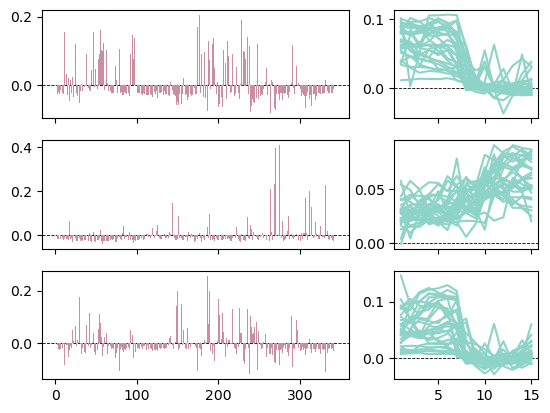

In [6]:
# plot factors
fig, axs = plt.subplots(rank,2, sharex="col", width_ratios=[1.5,0.7])

for r in range(rank):
    axs[r,0].axhline(0, linestyle="dashed", linewidth=0.6, c='k',zorder=0)
    axs[r,0].bar(np.arange(1,np.shape(A)[0]+1), A[:,r], color='#cb8da0')
    axs[r,1].axhline(0, linestyle="dashed", linewidth=0.6, c='k',zorder=0)  
    axs[r,1].plot((range(1,B[0].shape[0]+1)), cB[:,:,r].T, color="#8dd3c7")